In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, utils, datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import matplotlib.pyplot as plt

# Print the list of available GPUs
print(tf.config.list_physical_devices('GPU'))

NAME = "CIFAR10-{}".format(int(time.time()))
#tensorboard  = TensorBoard(log_dir='logs/{}'.format(NAME))
#early_stopping = EarlyStopping(monitor="val_accuracy", patience=3)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Load the CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize the images to have values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to categorical (one-hot encoding)
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

In [3]:
# Define spatial attention block
def spatial_attention_block1(input_tensor):
    # Compute the average and maximum across the channel dimension
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_tensor)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_tensor)
    
    # Concatenate the average and maximum
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    # Compute the spatial attention map
    spatial_attention = layers.Conv2D(1, kernel_size=(3, 3), padding='same', activation='sigmoid', use_bias=False, kernel_initializer='he_normal')(concat)
    
    # Multiply the input by the spatial attention map to get the output
    return layers.Multiply()([input_tensor, spatial_attention]), spatial_attention

# Define squeeze-and-excitation block
def squeeze_excite_block1(input_tensor, ratio=16):
    # Compute the number of filters
    filters = input_tensor.shape[-1]
    # Compute the squeeze operation (global average pooling)
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, filters))(se)
    # Perform the excitation operation (two fully-connected layers)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    # Multiply the input by the squeeze-and-excitation map
    se = layers.Multiply()([input_tensor, se])
    return se

# Define depthwise separable convolution block with squeeze-and-excitation and spatial attention
def depthwise_separable_conv_block(input_tensor, filters, strides=1, l2_reg=0.001):
    # Apply depthwise convolution
    x = layers.DepthwiseConv2D(kernel_size=(3, 3), strides=strides, padding='same', depthwise_regularizer=regularizers.l2(l2_reg))(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Apply pointwise convolution
    x = layers.Conv2D(filters, kernel_size=(1, 1), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Apply squeeze-and-excitation
    x = squeeze_excite_block1(x)
    # Apply spatial attention
    x, spatial_attention = spatial_attention_block1(x)
    return x, spatial_attention

# Function to get attention map from a model
def get_attention_map(model, spatial_attention_map, input_image):
    attention_model = models.Model(inputs=model.input, outputs=spatial_attention_map)
    attention_map = attention_model.predict(np.expand_dims(input_image, axis=0))[0]
    return attention_map

# Function to generate binary mask from attention map
def get_binary_mask(attention_map, threshold):
    binary_mask = np.zeros_like(attention_map)
    binary_mask[attention_map > threshold] = 1
    return binary_mask

# Function to apply binary mask to an image
def apply_binary_mask(input_image, binary_mask):
    resized_binary_mask = tf.image.resize(binary_mask, (input_image.shape[0], input_image.shape[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    expanded_binary_mask = tf.tile(resized_binary_mask, [1, 1, 3])
    masked_image = input_image * expanded_binary_mask.numpy()
    return masked_image


In [4]:
# Initialize the list for storing spatial attention maps
spatial_attention_maps = []

# Define the input layer of the network
input_tensor = layers.Input(shape=(32, 32, 3))

# Apply a convolutional layer to the input
x = layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding='same')(input_tensor)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# Apply depthwise separable convolution blocks with squeeze-and-excitation 
# and spatial attention for the specified number of filters and strides
for block_params in [(64, 1), (64, 2), (128, 1), (128, 2), (256, 1), (256, 2)]:
    x, spatial_attention = depthwise_separable_conv_block(x, block_params[0], strides=block_params[1])
    # Store the spatial attention map
    spatial_attention_maps.append(spatial_attention)

# Apply more depthwise separable convolution blocks with squeeze-and-excitation and spatial attention
for _ in range(3):
    x, spatial_attention = depthwise_separable_conv_block(x, 256)
    # Store the spatial attention map
    spatial_attention_maps.append(spatial_attention)

# Apply global average pooling and flatten the output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)

# Apply a fully-connected layer with ReLU activation and dropout
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Apply the output layer with softmax activation
output_tensor = layers.Dense(10, activation='softmax')(x)



In [5]:
# Define the model
model = models.Model(inputs=input_tensor, outputs=output_tensor)

# Define the learning rate schedule
lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)

# Compile the model with the Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

# Define the data augmentation generator
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=0.1)
# Fit the generator to the training data
datagen.fit(x_train)

# Define the batch size and number of epochs
batch_size = 50
epochs = 10

# Train the model using the augmented data and validate on the test set
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs, validation_data=(x_test, y_test))


Epoch 1/10
1000/1000 [==============================] - 105s 93ms/step - loss: 1.6591 - accuracy: 0.4008 - val_loss: 1.5021 - val_accuracy: 0.4825
Epoch 2/10
1000/1000 [==============================] - 89s 89ms/step - loss: 1.3241 - accuracy: 0.5406 - val_loss: 1.5905 - val_accuracy: 0.4728
Epoch 3/10
1000/1000 [==============================] - 90s 90ms/step - loss: 1.1567 - accuracy: 0.6080 - val_loss: 1.4448 - val_accuracy: 0.5447
Epoch 4/10
1000/1000 [==============================] - 87s 87ms/step - loss: 1.0297 - accuracy: 0.6549 - val_loss: 1.0127 - val_accuracy: 0.6679
Epoch 5/10
1000/1000 [==============================] - 87s 87ms/step - loss: 0.9414 - accuracy: 0.6900 - val_loss: 1.0254 - val_accuracy: 0.6746
Epoch 6/10
1000/1000 [==============================] - 87s 86ms/step - loss: 0.8764 - accuracy: 0.7144 - val_loss: 1.2994 - val_accuracy: 0.6074
Epoch 7/10
1000/1000 [==============================] - 92s 92ms/step - loss: 0.8252 - accuracy: 0.7328 - val_loss: 0.9305 

here (32, 32, 3)


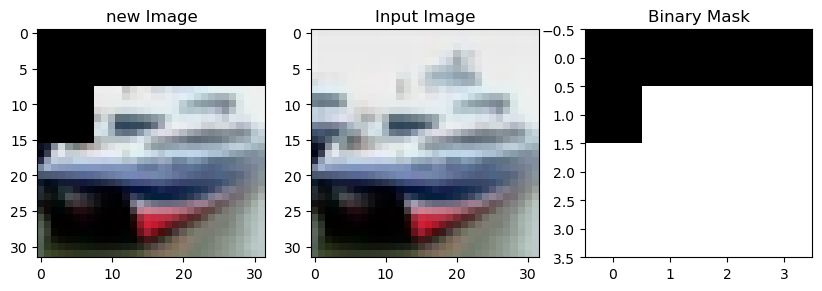

In [15]:
# Define a threshold for the binary mask
threshold = 0.6

# Choose an input image from your test set
input_image = x_test[1]

# Get the attention map for the last spatial_attention_map
attention_map = get_attention_map(model, spatial_attention_maps[-1], input_image)

# Get the binary mask for the attention map
binary_mask = get_binary_mask(attention_map, threshold)

# Apply the binary mask to the input image
new_img = apply_binary_mask(input_image, binary_mask)
print("here" , new_img.shape)

# Plot the new image, input image, and binary mask
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(new_img, cmap='gray')
ax1.set_title('new Image')

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(input_image, cmap='gray')
ax2.set_title('Input Image')

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(binary_mask, cmap='gray')
ax3.set_title('Binary Mask')

plt.show()

In [7]:
# Print the shapes of binary_mask, attention_map, and input_image
print(binary_mask.shape)
print(attention_map.shape)
print(input_image.shape)

(4, 4, 1)
(4, 4, 1)
(32, 32, 3)


In [8]:
# Evaluate the model on the test set and print the loss and accuracy
loss, accuracy = model.evaluate(x_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

# Evaluate the model on the test set again and print the loss and accuracy
loss, accuracy = model.evaluate(x_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

# Get the accuracy and loss for the final epoch of training and validation
last_epoch = len(history.history['accuracy']) - 1
train_accuracy = history.history['accuracy'][last_epoch]
train_loss = history.history['loss'][last_epoch]
val_accuracy = history.history['val_accuracy'][last_epoch]
val_loss = history.history['val_loss'][last_epoch]

# Print the final epoch training and validation accuracy and loss
print('\n')
print(f"Final epoch training accuracy: {train_accuracy:.4f}")
print(f"Final epoch training loss: {train_loss:.4f}")
print(f"Final epoch validation accuracy: {val_accuracy:.4f}")
print(f"Final epoch validation loss: {val_loss:.4f}")

313/313 [==============================] - 9s 28ms/step - loss: 1.2386 - accuracy: 0.6522
Test loss: 1.2385579347610474
Test accuracy: 0.6521999835968018
313/313 [==============================] - 10s 30ms/step - loss: 1.2386 - accuracy: 0.6522
Test loss: 1.2385579347610474
Test accuracy: 0.6521999835968018


Final epoch training accuracy: 0.7709
Final epoch training loss: 0.7197
Final epoch validation accuracy: 0.6522
Final epoch validation loss: 1.2386
